# objectives - get basic model tested after variance inflation factor used for feature selection

- check feature importance afterwards, 

- set up for advanced model tuning 

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.dummy import DummyRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.feature_selection import SelectKBest, f_regression
import seaborn as sns

In [2]:
df = pd.read_csv('../../data/model/final_df.csv')
df.rename(columns={"Asian or Asian/Pacific Islander - female [Public School] 2020-21":'APA_F',
                  'Current\nExpense Per ADA':'Current_Expense_per_ADA'}
       ,inplace=True)
df.drop(columns=['Unnamed: 0'],inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52665 entries, 0 to 52664
Data columns (total 23 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   Mean Scale Score                             52665 non-null  float64
 1   Total Tested with Scores at Reporting Level  52665 non-null  float64
 2   Demographic Name                             52665 non-null  object 
 3   Student Group                                52665 non-null  object 
 4   District Type                                52665 non-null  object 
 5   Test ID                                      52665 non-null  object 
 6   School Type                                  52665 non-null  object 
 7   Education_type                               52665 non-null  object 
 8   Charter_School                               52665 non-null  int64  
 9   Low Grade                                    52665 non-null  object 
 10

In [3]:
df.head()

,Mean Scale Score,Total Tested with Scores at Reporting Level,Demographic Name,Student Group,District Type,Test ID,School Type,Education_type,Charter_School,Low Grade,...,Pupil/Teacher-Ratio,Hispanic_Female,Black_or_AA_F,APA_F,Avg_21,Average Salary Paid,Current_Expense_per_ADA,est_num_u17_pov,Grocery_3mile,Grocery_dist
0,2579.7,106.0,All Students,All Students,County Office of Education (COE),English Language Arts/Literacy,K-12 Schools (Public),Traditional,1,"5,4,3,2,1",...,20.652848,194.364754,32.206967,361.873975,754920.0,85586.372299,13998.450902,3044.345812,50.0,1372.0
1,2582.4,56.0,Male,Gender,County Office of Education (COE),English Language Arts/Literacy,K-12 Schools (Public),Traditional,1,"5,4,3,2,1",...,20.652848,194.364754,32.206967,361.873975,754920.0,85586.372299,13998.450902,3044.345812,50.0,1372.0
2,2577.0,50.0,Female,Gender,County Office of Education (COE),English Language Arts/Literacy,K-12 Schools (Public),Traditional,1,"5,4,3,2,1",...,20.652848,194.364754,32.206967,361.873975,754920.0,85586.372299,13998.450902,3044.345812,50.0,1372.0
3,2600.2,91.0,IFEP and EO (Initial fluent English proficient...,English-Language Fluency,County Office of Education (COE),English Language Arts/Literacy,K-12 Schools (Public),Traditional,1,"5,4,3,2,1",...,20.652848,194.364754,32.206967,361.873975,754920.0,85586.372299,13998.450902,3044.345812,50.0,1372.0
4,2614.4,24.0,RFEP (Reclassified fluent English proficient),English-Language Fluency,County Office of Education (COE),English Language Arts/Literacy,K-12 Schools (Public),Traditional,1,"5,4,3,2,1",...,20.652848,194.364754,32.206967,361.873975,754920.0,85586.372299,13998.450902,3044.345812,50.0,1372.0


In [4]:
## add random variable to compare variable inportance too 

In [5]:
df['random'] = np.random.random(size = len(df))

In [6]:
df.columns

Index(['Mean Scale Score', 'Total Tested with Scores at Reporting Level',
       'Demographic Name', 'Student Group', 'District Type', 'Test ID',
       'School Type', 'Education_type', 'Charter_School', 'Low Grade',
       'Free_Meal_count', 'Latitude', 'FTE_Teachers', 'Pupil/Teacher-Ratio',
       'Hispanic_Female', 'Black_or_AA_F', 'APA_F', 'Avg_21',
       'Average Salary Paid', 'Current_Expense_per_ADA', 'est_num_u17_pov',
       'Grocery_3mile', 'Grocery_dist', 'random'],
      dtype='object')

## Decrease categories for one hote encoding 

In [7]:
df['Low Grade'] = df['Low Grade'].replace({'P':'K','5,4,3,2,1':'6',
                                           '11 or 8':'11,10,8',
                                          '10':'11,10,8'})

In [8]:
df['Low Grade'].value_counts()

9          42218
K           5085
6           2536
7           1941
11,10,8      885
Name: Low Grade, dtype: int64

In [9]:
df['Low Grade'].unique().tolist()

['6', '9', 'K', '7', '11,10,8']

## One hot encode categotical columns 

In [10]:
# creating instance of one-hot-encoder
enc = OneHotEncoder(handle_unknown='error',drop='first')


enc_df = pd.DataFrame(enc.fit_transform(df[['Low Grade']]).toarray(),
                    )
enc_df.columns =   enc.get_feature_names_out(['Low Grade'])
enc_df
# # merge with main df bridge_df on key values
df = df.join(enc_df)
df.drop('Low Grade',inplace=True,axis=1)
# df.head()

In [11]:
# creating instance of one-hot-encoder
enc = OneHotEncoder(handle_unknown='error',drop='first')


enc_df = pd.DataFrame(enc.fit_transform(df[['Test ID']]).toarray(),
                    )
enc_df.columns =   enc.get_feature_names_out(['Test ID'])
enc_df
# # merge with main df bridge_df on key values
df = df.join(enc_df)
df.drop('Test ID',inplace=True,axis=1)
# df.head()

In [12]:
enc = OneHotEncoder(handle_unknown='error',drop='first')


enc_df = pd.DataFrame(enc.fit_transform(df[['Demographic Name']]).toarray(),
                    )
enc_df.columns =   enc.get_feature_names_out(['Demographic Name'])
enc_df
# # merge with main df bridge_df on key values
df = df.join(enc_df)
df.drop('Demographic Name',inplace=True,axis=1)

In [13]:
df.shape

(52665, 56)

In [45]:
 X_train, X_test, y_train, y_test = train_test_split(  df.drop(columns=['Mean Scale Score',
                                                        'Student Group', 'District Type', 
       'School Type', 'Education_type']),df['Mean Scale Score'] ,
                                                     test_size=0.2, random_state=42)
    
    

## dummy regressor 

In [46]:
train_mean = y_test.mean()

In [47]:
dumb_reg = DummyRegressor(strategy='mean')
dumb_reg.fit(X_train, y_train)
dumb_reg.constant_

array([[2572.20945837]])

In [48]:
y_tr_pred = train_mean * np.ones(len(y_train))
r2_score(y_train, y_tr_pred)

-0.0003019727889708168

In [49]:
y_te_pred = train_mean * np.ones(len(y_test))
r2_score(y_test,y_te_pred)

0.0

In [50]:
mean_absolute_error(y_test, y_te_pred)

62.00801134344345

### using a dummy model with the mean scores predicts 0% of the variance in the data set and is off on average of 62 points 

## Create pipeline for linear model 

In [51]:
scaler = StandardScaler()
scaler.fit(X_train)
X_tr_scaled = scaler.transform(X_train)
X_te_scaled = scaler.transform(X_test)

In [52]:
lm = LinearRegression().fit(X_tr_scaled,y_train)

In [53]:
y_tr_pred = lm.predict(X_tr_scaled)
y_te_pred = lm.predict(X_te_scaled)

In [54]:
median_r2 = r2_score(y_train, y_tr_pred), r2_score(y_test, y_te_pred)
median_r2

(0.5929276596857331, 0.5891566833659732)

In [55]:
median_mae = mean_absolute_error(y_train, y_tr_pred), mean_absolute_error(y_test, y_te_pred)
median_mae

(37.761375751237146, 37.772111780435914)

In [56]:
X_train.shape

(42132, 51)

In [57]:
pipe = make_pipeline(
    StandardScaler(),
    SelectKBest(score_func=f_regression,k=40),
    LinearRegression()
)

In [58]:
pipe.fit(X_train,y_train)
y_tr_pred = pipe.predict(X_train)
y_te_pred = pipe.predict(X_test)

In [59]:
r2_score(y_train, y_tr_pred), r2_score(y_test, y_te_pred)

(0.5907573957525171, 0.5861011699867865)

In [60]:
mean_absolute_error(y_train, y_tr_pred), mean_absolute_error(y_test, y_te_pred)

(37.89311535187207, 37.93654952465795)

In [61]:
cv_results = cross_validate(pipe, X_train,y_train, cv=5)
cv_scores = cv_results['test_score']
np.mean(cv_scores), np.std(cv_scores)

(0.5900851521832113, 0.005798508674740059)

## cross validation does not increase r2 , small variation between models 

## look to use grid search on number of features for hypter paramter tuning 

In [62]:
k = [k+1 for k in range(len(X_train.columns))]
grid_params = {'selectkbest__k': k}

In [63]:
from sklearn.model_selection import GridSearchCV

In [64]:
pipe = make_pipeline(
    StandardScaler(),
    SelectKBest(score_func=f_regression),
    LinearRegression()
)

In [65]:
lr_grid_cv = GridSearchCV(pipe,param_grid= grid_params, cv=5, n_jobs=-1)

In [66]:
lr_grid_cv.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('selectkbest',
                                        SelectKBest(score_func=<function f_regression at 0x7fb0d4bf7820>)),
                                       ('linearregression',
                                        LinearRegression())]),
             n_jobs=-1,
             param_grid={'selectkbest__k': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
                                            12, 13, 14, 15, 16, 17, 18, 19, 20,
                                            21, 22, 23, 24, 25, 26, 27, 28, 29,
                                            30, ...]})

In [67]:
score_mean = lr_grid_cv.cv_results_['mean_test_score']
score_std = lr_grid_cv.cv_results_['std_test_score']
cv_k = [k for k in lr_grid_cv.cv_results_['param_selectkbest__k']]

In [68]:
lr_grid_cv.best_params_

{'selectkbest__k': 50}

In [70]:
lr_grid_cv.best_estimator_

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('selectkbest',
                 SelectKBest(k=50,
                             score_func=<function f_regression at 0x7fb0d4bf7820>)),
                ('linearregression', LinearRegression())])

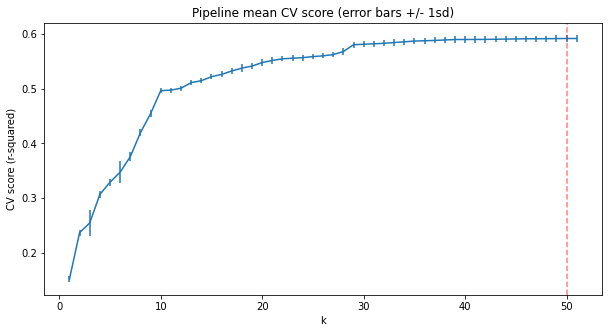

In [71]:
best_k = lr_grid_cv.best_params_['selectkbest__k']
plt.subplots(figsize=(10, 5))
plt.errorbar(cv_k, score_mean, yerr=score_std)
plt.axvline(x=best_k, c='r', ls='--', alpha=.5)
plt.xlabel('k')
plt.ylabel('CV score (r-squared)')
plt.title('Pipeline mean CV score (error bars +/- 1sd)');

In [73]:
selected = lr_grid_cv.best_estimator_.named_steps.selectkbest.get_support()
coefs = lr_grid_cv.best_estimator_.named_steps.linearregression.coef_
features = X_train.columns[selected]
pd.Series(coefs, index=features).sort_values(ascending=False)

Pupil/Teacher-Ratio                                                                  24.079475
FTE_Teachers                                                                         23.875843
Avg_21                                                                               15.803694
Low Grade_9                                                                          12.883872
Demographic Name_Asian                                                               11.943489
Demographic Name_Graduate school/Post graduate                                        8.379399
Demographic Name_IFEP (Initial fluent English proficient)                             7.492529
Demographic Name_White                                                                6.712258
Low Grade_7                                                                           6.445930
Low Grade_6                                                                           6.270734
Total Tested with Scores at Reporting Level       

## really interesting take aways about positive and negative coeeficents to compare to random forest model next 

In [ ]:
rf = RandomForestRegressor(n_estimators = 100,
                           n_jobs = -1,
                           oob_score = True,
                           bootstrap = True,
                           random_state = 42)
rf.fit(X_train, y_train)

             

In [ ]:
print('R^2 Training Score: {:.2f} \nOOB Score: {:.2f} \nR^2 Validation Score: {:.2f}'.format(rf.score(X_train, y_train), 
                                                                                             rf.oob_score_,
                                                                                             rf.score(X_test, y_test)))


In [ ]:
y_te_rf_pred=rf.predict(X_test)

In [ ]:
r2_score(y_test,y_te_rf_pred)

## over fitting with OOB and validation much lower than training 

In [ ]:
# https://github.com/erykml/medium_articles/blob/master/Machine%20Learning/feature_importance.ipynb

# function for creating a feature importance dataframe
def imp_df(column_names, importances):
    df = pd.DataFrame({'feature': column_names,
                       'feature_importance': importances}) \
           .sort_values('feature_importance', ascending = False) \
           .reset_index(drop = True)
    return df

# plotting a feature importance dataframe (horizontal barchart)
def var_imp_plot(imp_df, title):
    imp_df.columns = ['feature', 'feature_importance']
    fig ,ax = plt.subplots(figsize=(12,12))
    fig = sns.barplot(x = 'feature_importance', y = 'feature', data = imp_df, orient = 'h', color = 'royalblue') \
       .set_title(title, fontsize = 20)
    sns.despine()

In [ ]:
base_imp = imp_df(X_train.columns, rf.feature_importances_)
base_imp[:20]

In [ ]:
var_imp_plot(base_imp, 'Default feature importance (scikit-learn)')

## Without any cateorical features asain/ pacific islander population has the greatest feature inportance. Total students tested at level and puupul teacher ratio are the only other features about the ranom feature added. 

